# AAI614: Data Science & its Applications

*Notebook 6.2: K-Means Clustering*

<a href="https://colab.research.google.com/github/harmanani/AAI614/blob/main/Week%206/Notebook6.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: This notebook contains excerpts from *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow by Aurélien Géron*

This lab requires Scikit-Learn ≥ 1.0.1:

In [4]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Define the default font sizes to make the figures prettier:

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Import Libraries

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture

from sklearn.datasets import load_iris


## K-Means

**Fit and predict**

Let's train a K-Means clusterer on a dataset if blobs. It will try to find each blob's center and assign each instance to the closest blob:

In [12]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# extra code – the exact arguments of make_blobs() are not important
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

Explicitly set `n_init=10` when creating a `KMeans` estimator to avoid a warning about the fact that the default value for this hyperparameter will change from 10 to `"auto"` in Scikit-Learn 1.4.

Now let's plot them:

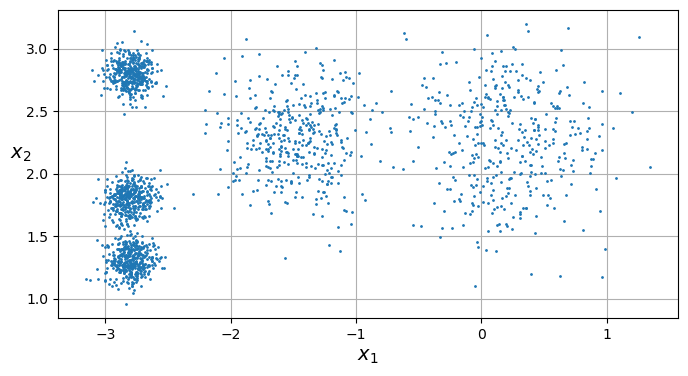

In [15]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
#save_fig("blobs_plot")
plt.show()

Each instance was assigned to one of the 5 clusters:

In [17]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

In [18]:
y_pred is kmeans.labels_

True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [20]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to (they are not targets, they are predictions):

In [22]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0])

Of course, we can predict the labels of new instances:

In [24]:
import numpy as np

X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

**Decision Boundaries**

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

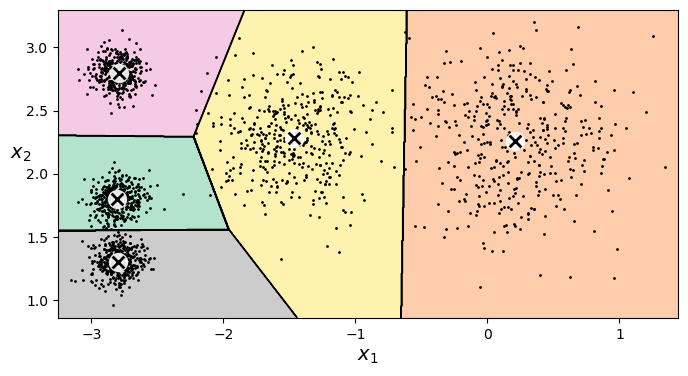

In [27]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

**Hard Clustering _vs_ Soft Clustering**

Rather than arbitrarily choosing the closest cluster for each instance, which is called _hard clustering_, it might be better to measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

In [31]:
kmeans.transform(X_new).round(2)

array([[2.81, 0.33, 2.9 , 1.49, 2.89],
       [5.81, 2.8 , 5.85, 4.48, 5.84],
       [1.21, 3.29, 0.29, 1.69, 1.71],
       [0.73, 3.22, 0.36, 1.55, 1.22]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [33]:
# extra code
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2)
               - kmeans.cluster_centers_, axis=2).round(2)

array([[2.81, 0.33, 2.9 , 1.49, 2.89],
       [5.81, 2.8 , 5.85, 4.48, 5.84],
       [1.21, 3.29, 0.29, 1.69, 1.71],
       [0.73, 3.22, 0.36, 1.55, 1.22]])

### The K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:
* First initialize $k$ centroids randomly: e.g., $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class uses an optimized initialization technique by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"` and `n_init=1`. More on this later in this chapter.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

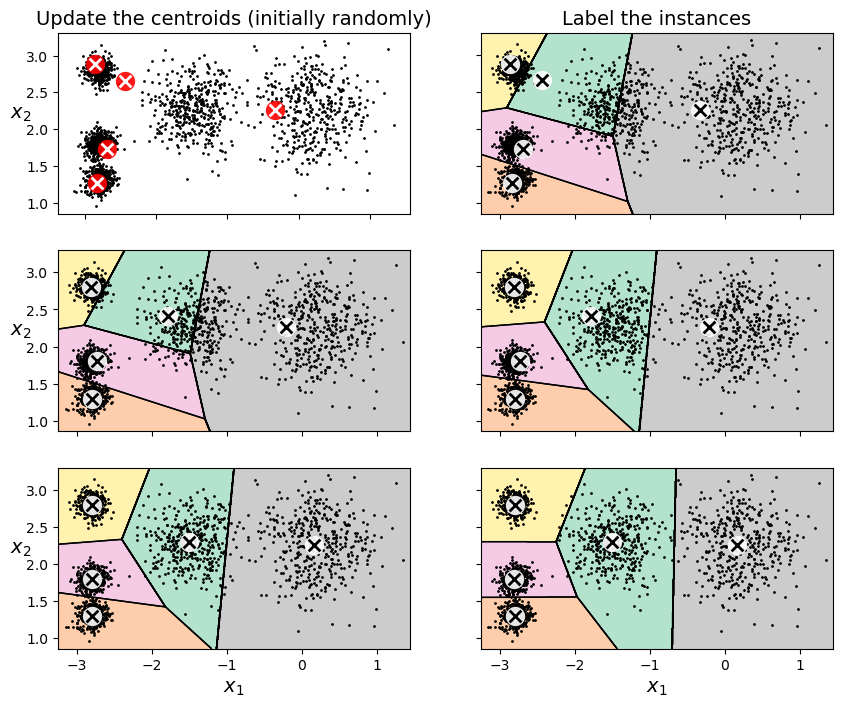

In [38]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=1,
                      random_state=5)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=2,
                      random_state=5)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=3,
                      random_state=5)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False,
                         show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False,
                         show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False,
                         show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

**K-Means Variability**

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

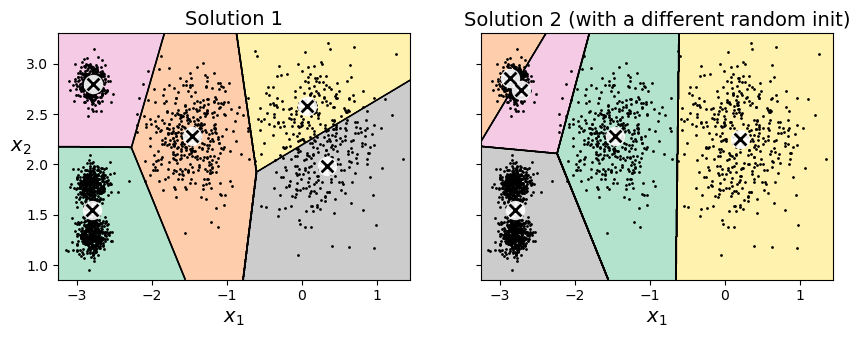

In [41]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None,
                              title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=9)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1",
                          "Solution 2 (with a different random init)")

#save_fig("kmeans_variability_plot")
plt.show()

In [42]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

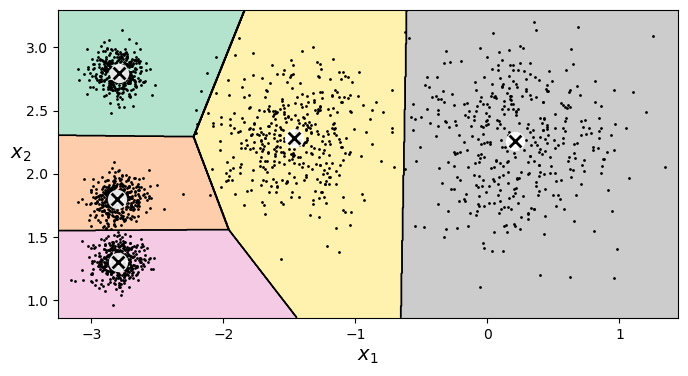

In [43]:
# extra code
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [46]:
kmeans.inertia_

211.59853725816828

In [47]:
kmeans_rnd_init1.inertia_  

219.435394427714

In [48]:
kmeans_rnd_init2.inertia_ 

258.64724728961613

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [50]:
X_dist = kmeans.transform(X)
(X_dist[np.arange(len(X_dist)), kmeans.labels_] ** 2).sum()

211.59853725816882

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_greater is better_" rule.

In [52]:
kmeans.score(X)

-211.59853725816828

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [56]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(init='random', n_clusters=5, random_state=2)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

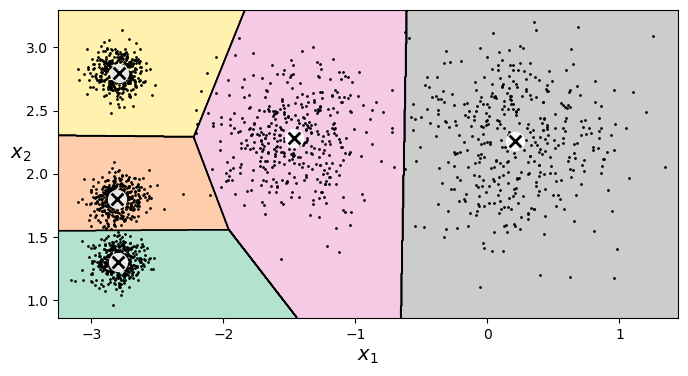

In [58]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

In [59]:
kmeans_rnd_10_inits.inertia_

211.59853725816828